In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'https://www.imdb.com/chart/tvmeter/'

headers={"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.5 Safari/605.1.15"}

page = requests.get(url, headers=headers)

page.raise_for_status()

soup = BeautifulSoup(page.text, 'html.parser')

In [3]:
tv_shows = soup.find('ul', class_= 'ipc-metadata-list ipc-metadata-list--dividers-between sc-3f13560f-0 sTTRj compact-list-view ipc-metadata-list--base')

In [4]:
tv_show_info = tv_shows.find_all('li', class_="ipc-metadata-list-summary-item sc-bca49391-0 eypSaE cli-parent")

In [5]:
len(tv_show_info)

100

In [6]:
ranks=[]
names=[]
years=[]
num_of_episodes=[]
ratings=[]
content=[]


for tv_show in tv_show_info:
    rank = tv_show.find('div', class_="sc-94da5b1b-0 kaCAvv meter-const-ranking sc-b85248f1-4 kWHdoO cli-meter-title-header").text[0:3].strip('()')
    ranks.append(rank)
    name = tv_show.find('h3', class_='ipc-title__text').text
    names.append(name)
    year = tv_show.find('span', class_='sc-b85248f1-6 bnDqKN cli-title-metadata-item').text[0:4]
    years.append(year)
    episode = tv_show.find('div', class_='sc-b85248f1-5 kZGNjY cli-title-metadata').find_all('span')[1].text[:-4]
    num_of_episodes.append(episode)

    try:
        rating = tv_show.find('span', class_='ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating').text[0:3]
        ratings.append(rating)
    except Exception as e:
        e = 'Not Available'
        ratings.append(e)
    try:
        content_rating = tv_show.find('div', class_='sc-b85248f1-5 kZGNjY cli-title-metadata').find_all('span')[2].text
        content.append(content_rating)
    except Exception as e:
        e = 'Not Rated'
        content.append(e)
    

In [7]:
df = pd.DataFrame()
df['Rank'] = ranks
df['Title'] = names
df['Start Year'] = years
df['Rating'] = ratings
df['Number of Episodes'] = num_of_episodes
df['Content Rating'] = content

In [8]:
df.head()

,Rank,Title,Start Year,Rating,Number of Episodes,Content Rating
0,1,Ahsoka,2023,8.1,8,Not Rated
1,2,Suits,2011,8.4,134,TV-14
2,3,Only Murders in the Building,2021,8.1,30,TV-MA
3,4,The Bear,2022,8.6,18,TV-MA
4,5,Painkiller,2023,7.5,6,TV-MA


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
Rank                  100 non-null object
Title                 100 non-null object
Start Year            100 non-null object
Rating                100 non-null object
Number of Episodes    100 non-null object
Content Rating        100 non-null object
dtypes: object(6)
memory usage: 4.8+ KB


In [10]:
#convert numeric values
df[["Rank", "Rating", "Number of Episodes", "Start Year"]] = df[["Rank", "Rating", "Number of Episodes", "Start Year"]].apply(pd.to_numeric, errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
Rank                  100 non-null int64
Title                 100 non-null object
Start Year            100 non-null int64
Rating                98 non-null float64
Number of Episodes    100 non-null int64
Content Rating        100 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ KB


In [12]:
df.describe()

,Rank,Start Year,Rating,Number of Episodes
count,100.000000,100.000000,98.000000,100.000000
mean,50.500000,2015.150000,8.084694,91.510000
std,29.011492,8.297955,0.810034,143.555817
min,1.000000,1989.000000,5.200000,6.000000
25%,25.750000,2010.000000,7.625000,17.750000
50%,50.500000,2018.500000,8.150000,31.000000
75%,75.250000,2022.000000,8.700000,122.750000
max,100.000000,2023.000000,9.500000,1081.000000


In [13]:
# fill 2 NaN values in Rating with mean rating
df['Rating'] = df['Rating'].fillna(8)

In [14]:
# count the number of tv shows in each content rating group
content_df = df.groupby('Content Rating').count()
content_df

,Rank,Title,Start Year,Rating,Number of Episodes
Content Rating,,,,,
Not Rated,4,4,4,4,4
TV-14,26,26,26,26,26
TV-MA,61,61,61,61,61
TV-PG,8,8,8,8,8
TV-Y7-FV,1,1,1,1,1


<Figure size 432x288 with 0 Axes>

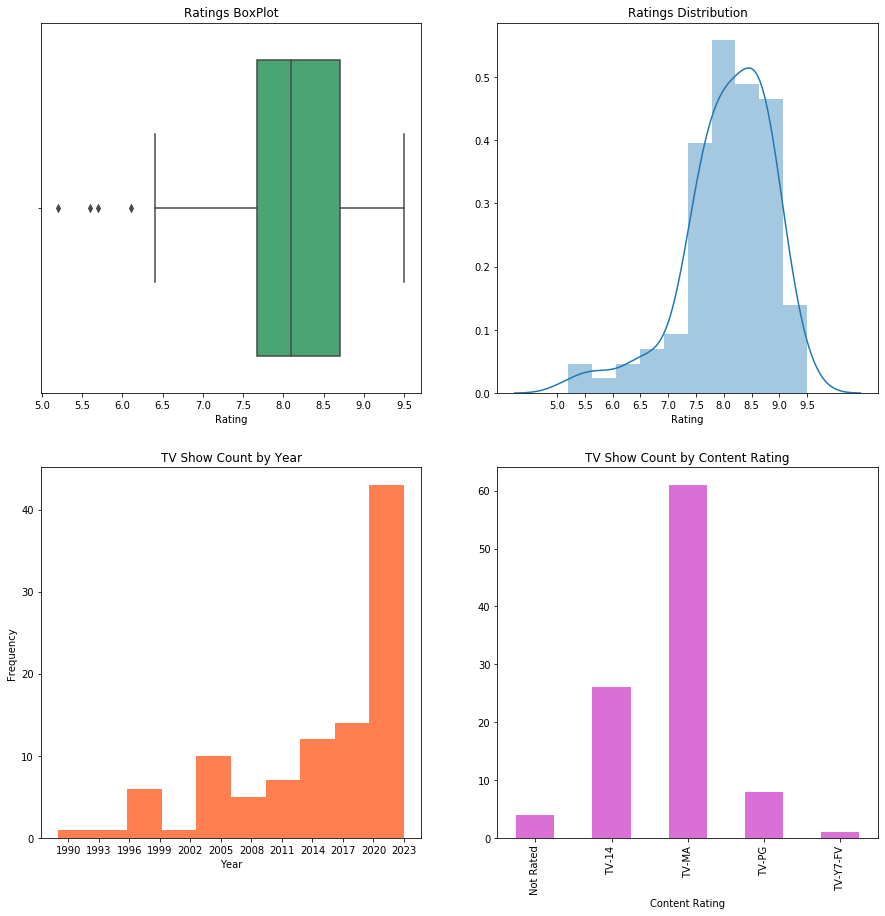

<Figure size 432x288 with 0 Axes>

In [15]:
fig = plt.figure(figsize = (15,15))
spec = fig.add_gridspec(ncols=2, nrows=2)
plt.subplot(spec[0, 0], title='Ratings BoxPlot')
sns.boxplot(df.Rating, color='mediumseagreen')
plt.xticks(np.arange(5, 10, .5))
plt.subplot(spec[0, 1], title='Ratings Distribution')
sns.distplot(df.Rating)
plt.xticks(np.arange(5, 10, .5))
plt.subplot(spec[1, 0], title='TV Show Count by Year', xlabel='Year')
df['Start Year'].plot.hist(color = 'coral')
plt.xticks(np.arange(1990, 2024, 3))
plt.subplot(spec[1, 1], title='TV Show Count by Content Rating')
content_df['Title'].plot(kind = 'bar', color='orchid')
plt.figure()

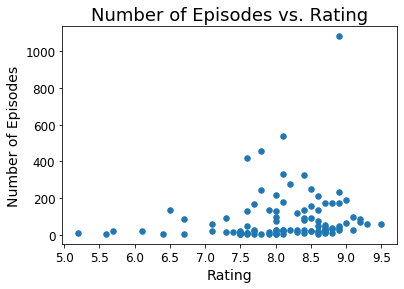

In [16]:
plt.scatter(x=df['Rating'], y=df['Number of Episodes'], s=30)
plt.title('Number of Episodes vs. Rating', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Episodes', fontsize=14)
plt.xticks(np.arange(5, 10, 0.5))
plt.tick_params(labelsize=12);

In [17]:
# identify the outlier
df[(df['Number of Episodes'] > 1000)]

,Rank,Title,Start Year,Rating,Number of Episodes,Content Rating
39,40,One Piece,1999,8.9,1081,TV-14


In [18]:
high_rating_df = df[df.Rating > 8.4].sort_values('Rating')

([<matplotlib.axis.XTick at 0x7f960634b7f0>,
 <a list of 20 Text xticklabel objects>)

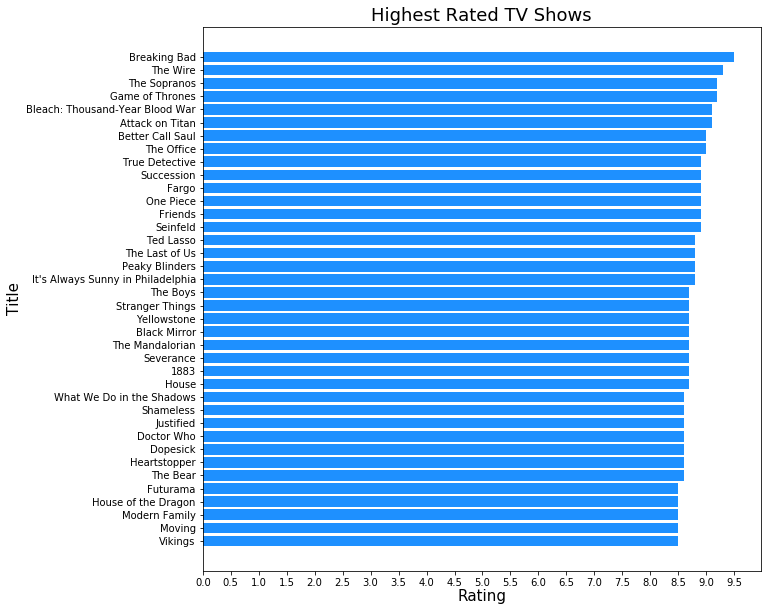

In [19]:
#plt.style.use('Solarize_Light2')
plt.figure(figsize=(10,10))
plt.title("Highest Rated TV Shows", size=18)
plt.barh('Title', 'Rating',data=high_rating_df, color='dodgerblue')
plt.xlabel("Rating", labelpad=1, size=15)
plt.ylabel("Title", size=15)
plt.xticks(np.arange(0, 10, 0.5))

In [20]:
low_rating_df = df[df.Rating < 8.0].sort_values('Rating', ascending=False)

([<matplotlib.axis.XTick at 0x7f96066f0b70>,
 <a list of 17 Text xticklabel objects>)

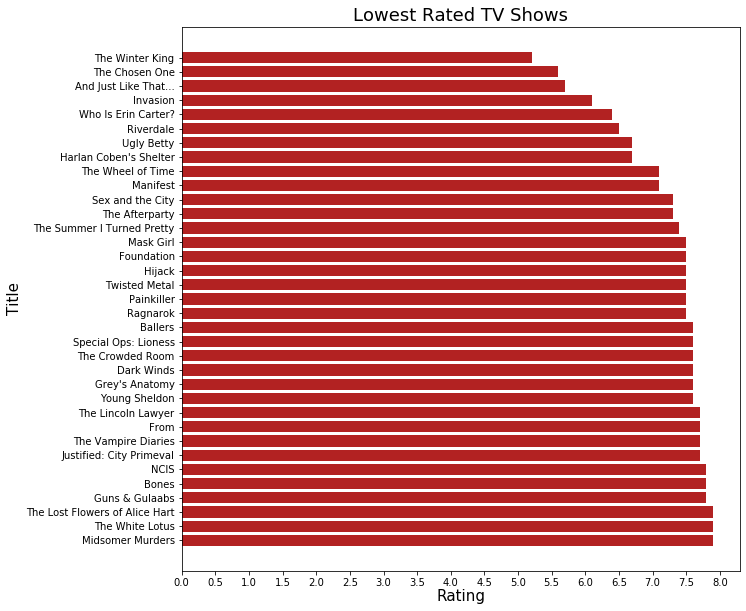

In [21]:
plt.figure(figsize=(10,10))
plt.title("Lowest Rated TV Shows", size=18)
plt.barh('Title', 'Rating',data=low_rating_df, color='firebrick')
plt.xlabel("Rating", labelpad=1, size=15)
plt.ylabel("Title", size=15)
plt.xticks(np.arange(0, 8.5, 0.5))